In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import quad
import QuantLib as ql
import pandas as pd

def generate_multi_paths_df(process, num_paths=1000, timestep=24, length=2, ld=False, brownianBridge=False):
    """Generates multiple paths from an n-factor process, each factor is returned in a seperate df"""
    times = ql.TimeGrid(length, timestep)
    dimension = process.factors()

    if ld:
        rng = ql.UniformLowDiscrepancySequenceGenerator(dimension * timestep)
        seq = ql.GaussianLowDiscrepancySequenceGenerator(rng)
        path_gen = ql.GaussianSobolMultiPathGenerator(process, times, seq, brownianBridge)
    else:
        rng = ql.UniformRandomSequenceGenerator(dimension * timestep, ql.UniformRandomGenerator())
        seq = ql.GaussianRandomSequenceGenerator(rng)
        path_gen = ql.GaussianMultiPathGenerator(process, list(times), seq, brownianBridge)

    paths = [[] for i in range(dimension)]

    for i in range(num_paths):
        sample_path = path_gen.next()
        values = sample_path.value()
        spot = values[0]

        for j in range(dimension):
            paths[j].append([x for x in values[j]])

    df_paths = [pd.DataFrame(path, columns=[spot.time(x) for x in range(len(spot))]) for path in paths]

    return df_paths

In [2]:
# Setting up the pricing and Heston parameters - as described in (Table 1)
K, spot = 100, 100
T, t = 1.5, 0.0
r, q = 0.05, 0.0

vol = 0.3
v0 = vol * vol
kappa = 1.15
theta = 0.348
rho = -0.64
sigma = 0.39

In [3]:
global lookup, calls
lookup = {}
calls = []

# Eq. (21)
def f(tau, n, z1, z2, z3, z4):
    calls.append(n)
    if n < 2:
        if n < 0:
            result = 0
        if n == 0:
            result = 1
        if n == 1:
            result = 0.5*(kappa - z4*sigma**2)*tau
    else:
        # f is heavily recursive, need a dynamic programming solution
        # or else it becomes extremely heavy to calculate
        f_minus_n = [0, 0, 0, 0]
        for i in range(4):
            if n-(i+1) in lookup:
                f_minus_n[i] = lookup[n-(i+1)]
            else:
                f_minus_n[i] = f(tau, n-(i+1), z1, z2, z3, z4)

        prefactor = -sigma**2 * tau**2 / (2*n*(n-1))
        result = prefactor * (z1*tau**2 * f_minus_n[3] + z2*tau*f_minus_n[2] + (z3 - kappa**2/(2*sigma**2))*f_minus_n[1])

    lookup[n] = result
    return result

In [4]:
# Eq. (19), (20)
def F_F_tilde(tau, z1, z2, z3, z4, n_lim=50):
    n_range = range(n_lim)
    f_vals = [f(tau, x, z1, z2, z3, z4) for x in n_range]

    F = sum(f_vals)
    F_tilde = sum([x*f_vals[x] / tau for x in n_range])

    return F, F_tilde

# Eq. (13)
def z1_f(s, w, T):
    return s**2 * (1-rho**2) / (2*T**2)

def z2_f(s, w, T):
    return s*(2*rho*kappa - sigma) / (2*sigma*T) + s*w*(1-rho**2)/T

def z3_f(s, w, T):
    return s*rho/(sigma*T) + w*(2*rho*kappa - sigma)/(2*sigma) + w**2*(1-rho**2)/2

def z4_f(s,w):
    return w*rho/sigma

In [5]:
#TODO: How does Phi look for non-constant r/q? eg. Piecewise continuous but t-dependent?

# Eq. (25)
def Phi(s, w, t=t, T=T, n_lim=50):
    tau = T-t
    z1, z2, z3, z4 = z1_f(s, w, T), z2_f(s, w, T), z3_f(s, w, T), z4_f(s,w)

    a1 = 2 * v0 / sigma**2
    a2 = 2 * kappa * theta / sigma**2
    a3 = (tau/T)*np.log(spot) + ((r-q)*sigma - kappa*theta*rho)*tau**2/(2*sigma*T) - rho*tau*v0/(sigma*T)
    a4 = np.log(spot) - rho*v0/sigma + ((r-q) - rho*kappa*theta/sigma)*tau
    a5 = (kappa*v0 + kappa**2*theta*tau)/sigma**2

    lookup = {}
    F, F_tilde = F_F_tilde(tau, z1, z2, z3, z4, n_lim=n_lim)

    return np.exp(-a1 * F_tilde / F - a2 * np.log(F) + a3 * s + a4 * w + a5)

In [6]:
# And finally Eq. (29) - assuming an UNSEASONED option here
def C(K, T=T, t=t, n_lim=50):
    term_1 = 0.5 * (Phi(1, 0, t=t, T=T, n_lim=n_lim) - K)
    lnK = np.log(K)
    right_lim = 100

    integrand = lambda x: np.real((Phi(1.0 + 1j*x, 0, t=t, T=T, n_lim=n_lim) - K*Phi(1j*x, 0, t=t, T=T, n_lim=n_lim)) * np.exp(-1j*x*lnK) / (1j*x))
    integral = 1/np.pi * quad(integrand, 1e-15, right_lim, limit=2000)[0]

    dcf = np.exp(-r*(T-t))

    return dcf * (term_1 + integral)

In [7]:
C(K)

11.337419004831542

In [8]:
# Reproducing paper results - (Table 1)
Ks = [90, 95, 100, 105, 110]
Ts = [0.2, 1.5, 3.0]
results = []

for K_temp in Ks:
    for T_temp in Ts:
        results.append({"T": T_temp, "K": K_temp, "price": C(K_temp, T_temp)})

pd.DataFrame(results).set_index(["K", "T"]).unstack()

price                      
T          0.2        1.5        3.0
K                                   
90   10.657125  16.503015  20.510177
95    6.587123  13.762463  18.305967
100   3.447770  11.337419  16.289455
105   1.455177   9.224508  14.453127
110   0.472414   7.412154  12.788203

,0.000000,0.014423,0.028846,0.043269,0.057692,0.072115,0.086538,0.100962,0.115385,0.129808,...,1.370192,1.384615,1.399038,1.413462,1.427885,1.442308,1.456731,1.471154,1.485577,1.500000
0,100.0,101.669628,102.777094,102.835426,98.769392,98.020869,102.797441,93.911326,93.714492,95.114132,...,131.388903,141.927659,148.551755,151.884772,160.344241,156.272914,139.791899,135.734280,129.990927,138.669108
1,100.0,95.876398,101.173326,94.158484,92.109320,85.939699,88.670399,85.319575,93.186501,84.708759,...,105.084121,106.928395,112.943008,114.691193,110.421554,108.626694,112.997233,115.704324,128.157719,124.534867
2,100.0,97.905501,97.278097,100.232396,98.963892,100.750114,101.005911,97.771493,103.686100,103.595725,...,162.714741,143.484013,123.124733,140.125159,154.248748,154.334740,153.427039,165.529740,161.734637,152.728220
3,100.0,104.035021,111.172946,110.420204,111.058901,107.042187,108.732558,105.748778,102.097531,97.223792,...,158.200667,172.114844,155.026898,146.623871,138.361682,136.994583,144.247011,138.569624,143.698054,136.363482
4,100.0,98.541664,93.292091,93.661981,94.661853,97.631919,98.046270,100.103139,99.885514,104.583180,...,134.490311,130.117597,128.993435,127.468216,126.725849,131.749733,138.541579,137.658633,131.968854,115.368700


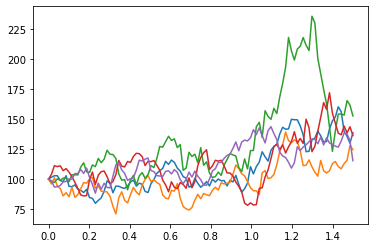

In [9]:
# Finally, manually simulate some Heston paths and generate an approximate numerical price as sanity check
today = ql.Date(26, 11, 2020)
spot_quote = ql.QuoteHandle(ql.SimpleQuote(spot))

day_count = ql.Actual365Fixed()
riskFreeCurve = ql.FlatForward(today, r, day_count)
dividendCurve = ql.FlatForward(today, q, day_count)
flat_ts = ql.YieldTermStructureHandle(riskFreeCurve)
dividend_ts = ql.YieldTermStructureHandle(dividendCurve)

samples, timesteps = 2**18, 104
heston_process = ql.HestonProcess(flat_ts, dividend_ts, spot_quote, v0, kappa, theta, sigma, rho)

paths = generate_multi_paths_df(heston_process, num_paths=samples, timestep=timesteps, length=T)[0]
plt.plot(paths.head().transpose())

paths.head()

In [10]:
paths_ex = paths.drop(0.0, axis=1)

payoff = np.exp(np.sum(np.log(paths_ex), axis=1) * (1/timesteps)).clip(K) - K
payoff.mean() * flat_ts.discount(T)

11.453842385299204